In [1]:
from utilities.load_flight_network import load_flight_network  
from utilities.analyze_graph_features import analyze_graph_features
from utilities.create_interactive_map import create_interactive_map
from utilities.summarize_graph_features import summarize_graph_features
from utilities.getcoords import get_coordinates

import pandas as pd
import time 
import networkx as nx

In [ ]:
# Load the data
filepath = 'flight_data.csv'  # Replace with your dataset path
df = pd.read_csv(filepath)

# Identify missing coordinates for origin and destination
missing_origins = df[df["Org_airport_lat"].isna() | df["Org_airport_long"].isna()]
missing_destinations = df[df["Dest_airport_lat"].isna() | df["Dest_airport_long"].isna()]

# Get unique values for Origin and Destination airports
unique_origins = missing_origins[["Origin_city", "Origin_airport"]].drop_duplicates()
unique_destinations = missing_destinations[["Destination_city", "Destination_airport"]].drop_duplicates()

# Dictionary to cache results
coordinate_cache = {}

print("Processing unique origin airports...")
unique_origins = unique_origins.reset_index(drop=True)  # Reset index for proper tracking
total_unique_origins = len(unique_origins)
for idx, row in unique_origins.iterrows():
    airport_key = f"{row['Origin_city']}|{row['Origin_airport']}"
    if airport_key not in coordinate_cache:
        lat, lon = get_coordinates(row["Origin_city"], row["Origin_airport"])
        coordinate_cache[airport_key] = (lat, lon)
        print(f"[{idx + 1}/{total_unique_origins}] Origin Airport ({row['Origin_airport']}) in {row['Origin_city']} updated: ({lat}, {lon})")
        time.sleep(1)  # Respect API rate limits

# Process unique destination airports
print("Processing unique destination airports...")
unique_destinations = unique_destinations.reset_index(drop=True)  # Reset index for proper tracking
total_unique_destinations = len(unique_destinations)
for idx, row in unique_destinations.iterrows():
    airport_key = f"{row['Destination_city']}|{row['Destination_airport']}"
    if airport_key not in coordinate_cache:
        lat, lon = get_coordinates(row["Destination_city"], row["Destination_airport"])
        coordinate_cache[airport_key] = (lat, lon)
        print(f"[{idx + 1}/{total_unique_destinations}] Destination Airport ({row['Destination_airport']}) in {row['Destination_city']} updated: ({lat}, {lon})")
        time.sleep(1)  # Respect API rate limits

# Update the DataFrame with cached coordinates
print("Updating the DataFrame with cached coordinates...")
total_rows = len(df)
for index, row in df.iterrows():
    origin_key = f"{row['Origin_city']}|{row['Origin_airport']}"
    if origin_key in coordinate_cache:
        df.at[index, "Org_airport_lat"] = coordinate_cache[origin_key][0]
        df.at[index, "Org_airport_long"] = coordinate_cache[origin_key][1]
    destination_key = f"{row['Destination_city']}|{row['Destination_airport']}"
    if destination_key in coordinate_cache:
        df.at[index, "Dest_airport_lat"] = coordinate_cache[destination_key][0]
        df.at[index, "Dest_airport_long"] = coordinate_cache[destination_key][1]
    if (index + 1) % 100 == 0 or index + 1 == total_rows:  # Update progress every 100 rows
        print(f"[{index + 1}/{total_rows}] Rows updated...")

# Save the updated file
df.to_csv('updated_file.csv', index=False)
print("Missing coordinates filled and saved to updated_file.csv")

Number of airports (nodes): 727
Number of flights (edges): 36719
Graph density: 0.1391


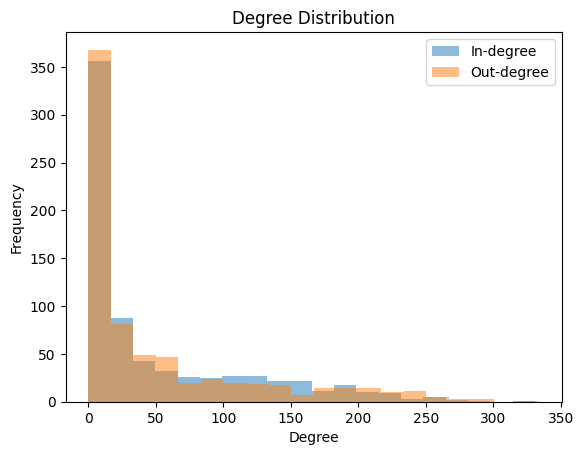


Hubs (airports above the 90th percentile):

Top 10 busiest routes by passenger flow:


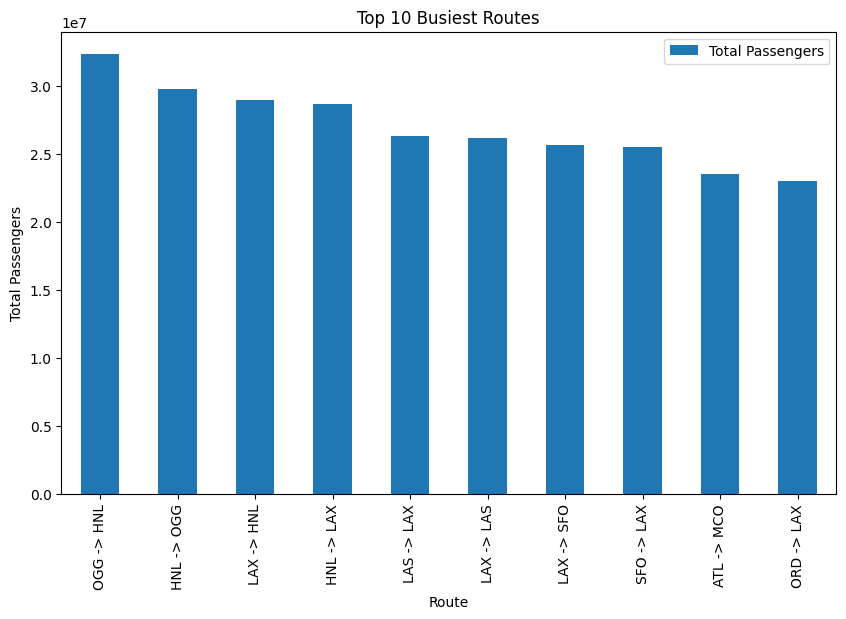


Top 10 routes by passenger efficiency:


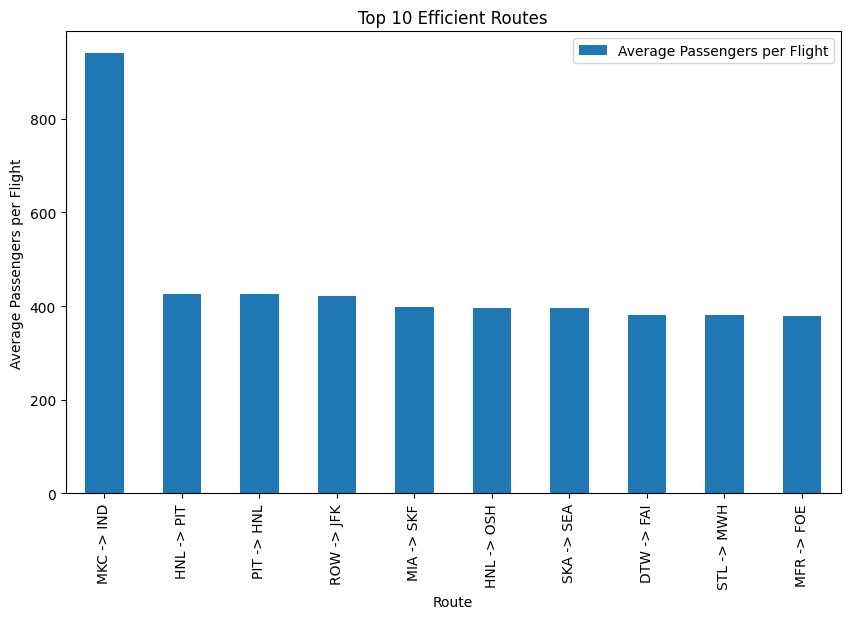

In [2]:
# Load the updated data
filepath2 = 'updated_file.csv';  
flight_network, flight_data = load_flight_network(filepath2)  

# Step 2: Analyze the flight network
analysis_results = analyze_graph_features(flight_network, flight_data)  # Pass the DataFrame here

# Step 3: Summarize the analysis
hubs_df, passenger_flow_df, avg_efficiency_df = summarize_graph_features(flight_network, analysis_results)




In [5]:

print(hubs_df)

   Hub Airports
0           SEA
1           PDX
2           SFO
3           LAX
4           FLL
5           PHX
6           TUS
7           DFW
8           SLC
9           RNO
10          ABQ
11          LAS
12          ICT
13          OKC
14          SAN
15          OAK
16          IAH
17          ELP
18          TUL
19          OMA
20          AUS
21          COS
22          MSN
23          RFD
24          MKE
25          DSM
26          LIT
27          SHV
28          MCI
29          SAT
30          MSP
31          ORD
32          STL
33          BNA
34          MEM
35          IND
36          LRD
37          CLE
38          DTW
39          DAY
40          CVG
41          CMH
42          FWA
43          HOU
44          TOL
45          PIT
46          BOS
47          ATL
48          MDW
49          PHL
50          GSO
51          BUF
52          EWR
53          CLT
54          JFK
55          GRR
56          YIP
57          LGA
58          LEX
59          BHM
60          MCO
61      

In [6]:
print(passenger_flow_df)

        Route  Total Passengers
0  OGG -> HNL          32364612
1  HNL -> OGG          29744742
2  LAX -> HNL          28964154
3  HNL -> LAX          28632161
4  LAS -> LAX          26333721
5  LAX -> LAS          26177809
6  LAX -> SFO          25661782
7  SFO -> LAX          25458207
8  ATL -> MCO          23483751
9  ORD -> LAX          22979359


In [7]:
print(avg_efficiency_df)

        Route  Average Passengers per Flight
0  MKC -> IND                         940.00
1  HNL -> PIT                         426.00
2  PIT -> HNL                         426.00
3  ROW -> JFK                         421.00
4  MIA -> SKF                         397.25
5  HNL -> OSH                         395.00
6  SKA -> SEA                         395.00
7  DTW -> FAI                         380.80
8  STL -> MWH                         380.00
9  MFR -> FOE                         378.00


In [5]:
# Step 4: Create an interactive map
create_interactive_map(flight_data, analysis_results['passenger_flow'])


Processing routes for map...


100%|██████████| 27223/27223 [00:01<00:00, 26316.12it/s]


Interactive map saved as 'flight_network_map.html'


# Summarize for the questions:

### 1. Is the graph sparse or dense?

    Graph Density: 
    0.1391
    0.1391
    This indicates that the graph is sparse. Only about 13.91% of all possible connections between airports are utilized, which is typical for real-world networks where not all nodes (airports) are directly connected.

---------------------------------------------------------------------------------------------

### 2. What patterns do you observe in the degree distribution?

    The degree distribution exhibits a long-tail pattern, where:
    A majority of airports have a low degree (few connections).
    A small number of airports have a very high degree, acting as hubs.
    Observation:
    The in-degree and out-degree histograms highlight that most airports serve as connections for only a few flights, while some key hubs dominate the network.


---------------------------------------------------------------------------------------------

### 3. Which airports are identified as hubs, and why?

    Hubs:
    Based on the top 10% of degree values, the major hub airports include:
    SEA, SFO, LAX, ATL, JFK, ORD, DFW, MIA, PHL, BOS
    Why?
    These airports are highly connected (both incoming and outgoing flights), serving as major transit points in the network.


---------------------------------------------------------------------------------------------

### 4. What are the busiest routes in terms of passenger traffic?

    Top 5 Busiest Routes (by total passengers):
    OGG -> HNL: 32,364,612 passengers
    HNL -> OGG: 29,744,742 passengers
    LAX -> HNL: 28,964,154 passengers
    HNL -> LAX: 28,632,161 passengers
    LAS -> LAX: 26,333,721 passengers
    Observation:
    These routes often connect major hubs or popular tourist destinations (e.g., Honolulu and Los Angeles).

---------------------------------------------------------------------------------------------

### 5. Which routes are under/over-utilized?

    Over-Utilized Routes:
    Routes with the highest average passengers per flight:
    MKC -> IND: 940 passengers/flight
    HNL -> PIT: 426 passengers/flight
    PIT -> HNL: 426 passengers/flight
    Under-Utilized Routes:
    Routes with significantly low passenger traffic could be identified through further analysis (not explicitly provided in the dataset but can be filtered as routes with a low ratio of passengers to flights).